# Wholesale Customers | Segmentation

In [1]:
#Data handling Imports
import pandas as pd
import numpy as np

#Notebook arrange Imports
import warnings
warnings.filterwarnings('ignore')

#Calculation Imports
import math
import random

#Visualisation Imports
import seaborn as sns
import pylab
pylab.style.use('seaborn-pastel')
import matplotlib.pyplot as plt
%matplotlib inline

#Feature Selection Imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect

#Outlier Handling Imports
from scipy.stats.mstats import winsorize

#Normalization & Scaler Imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.decomposition import PCA

#Sampling Imports
from sklearn.model_selection import KFold

#Encoding Imports
from sklearn.preprocessing import LabelEncoder

#Modeling Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#Clustering Imports
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
import scipy.cluster.hierarchy as shc

#Accuracy Validation Imports
from sklearn import metrics
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score,precision_recall_curve,\
confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

#Other required libraries
import time
start = time. time()

# [1] Data preprocessing

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
#Taking copy for missing value handling purpose
df_MV = df.copy()
# df.head()
df_MV.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
417,1,3,5065,5499,11055,364,3485,1063
332,1,2,22321,3216,1447,2208,178,2602
157,1,3,17773,1366,2474,3378,811,418
201,2,1,4484,14399,24708,3549,14235,1681
111,2,3,12579,11114,17569,805,6457,1519


In [3]:
#Checking the size of the dataset
df_MV.shape

(440, 8)

In [4]:
#Checking for missing values
df_MV.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [5]:
#As we don't have any missing values in dataset . checking structure to put sunthetic nulls
df_MV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
#Count of unique values and categories featurewise for Channel & Region Column
column_list = ['Channel','Region']
#print(column_list)
for col in column_list:
    print('Feature: {:<9s} | Unique-Count: {:<3} | Categories: {:}'.format(col,df_MV[col].nunique(),df_MV[col].unique()))

Feature: Channel   | Unique-Count: 2   | Categories: [2 1]
Feature: Region    | Unique-Count: 3   | Categories: [3 1 2]


In [7]:
#As dataset is not having any null values imputing null values to explain importance of preprocessing of null value handling
#Inserting 3% of each column's values as null... [Synthetic]
#As we have only 440 records.. doesn't want to distort..
ix = [(row, col) for row in range(df_MV.shape[0]) for col in range(df_MV.shape[1])]
for row, col in random.sample(ix, int(round(.03*len(ix)))):
    df_MV.iat[row, col] = None

In [8]:
#Checking null values after synthetic null insert
df_MV.isnull().sum().sort_values(ascending=False)

Fresh               17
Channel             16
Milk                16
Grocery             16
Detergents_Paper    12
Region              10
Delicassen          10
Frozen               9
dtype: int64

In [9]:
#Assigning unique category to region & Channel feature as '3' & '4' recpectively. For null handling
df_MV['Channel'] = df_MV['Channel'].fillna(3)
df_MV['Region'] = df_MV['Region'].fillna(4)
df_MV.isnull().sum().sort_values(ascending=False)

Fresh               17
Milk                16
Grocery             16
Detergents_Paper    12
Delicassen          10
Frozen               9
Channel              0
Region               0
dtype: int64

In [10]:
#For rest null value imputation let's check insight of data
df_MV.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,423.000000,424.000000,424.000000,431.000000,428.000000,430.000000
mean,1.386364,2.575000,12327.612293,5724.233491,7917.971698,3097.354988,2848.803738,1521.653488
std,0.557243,0.795095,12775.553034,7204.077957,9559.725170,4895.048871,4752.643625,2829.949415
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3349.500000,1490.500000,2127.000000,744.000000,261.500000,406.750000
50%,1.000000,3.000000,8708.000000,3649.500000,4785.500000,1541.000000,816.500000,965.500000
75%,2.000000,3.000000,17111.500000,7160.000000,10550.000000,3573.000000,3883.500000,1822.750000
max,3.000000,4.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [11]:
#Median and Mean by grouping cannel & region
df_MVal = df_MV.drop(['Channel','Region'], axis=1)
df_MV.groupby(['Channel', 'Region']).agg(['median','mean']).round(1)

Fresh              Milk           Grocery           Frozen  \
                 median     mean   median     mean   median     mean  median   
Channel Region                                                                 
1.0     1.0      8555.0  12829.2   2280.0   4057.5   2840.0   4179.2  1859.0   
        2.0      9790.0  12062.0   1610.0   2356.3   3558.0   4600.6  2696.5   
        3.0      9898.0  14292.2   2256.0   3447.6   2548.0   3750.4  2012.0   
        4.0     18692.0  23469.4   2295.0   2778.8   1765.0   2406.0  3220.0   
2.0     1.0      3064.5   5815.9   8053.0  10571.4  15445.0  18105.1  1285.0   
        2.0      6020.5   7335.4   6530.0   9084.6  12469.0  16326.3   918.0   
        3.0      7832.5  10203.0   7845.0  11007.7  11874.0  16221.2  1031.0   
        4.0      5626.0   9192.0  10556.0  10064.8  12477.0  13339.2  1920.0   
3.0     1.0     12051.5  12051.5   1343.0   1343.0   1138.0   1138.0  2146.5   
        2.0         NaN      NaN    899.0    899.0   1664.0   1664.0   414.0   
        3.0      4591.0   7778.4   2822.5   4597.8   6996.0   8938.9   959.0   

                       Detergents_Paper         Delicassen          
                  mean           median    mean     median    mean  
Channel Region                                                      
1.0     1.0     3180.5            413.5   987.3      786.0  1235.4  
        2.0     6053.9            351.0   497.3      898.0  1127.5  
        3.0     3795.3            372.5   756.5      833.0  1465.3  
        4.0     2670.0            312.0   439.8     1215.0  1568.8  
2.0     1.0     2527.4           6177.0  8152.4     1360.0  1883.2  
        2.0     1563.5           6094.0  8457.6     1069.5  1277.0  
        3.0     1461.3           5089.5  6928.9     1355.5  1849.9  
        4.0     2476.4           5038.0  6540.8     1426.0  1237.8  
3.0     1.0     2146.5            381.5   381.5      407.0   407.0  
        2.0      414.0             88.0    88.0      522.0   522.0  
        3.0     2357.5           1538.0  2958.7      483.0  2219.5

In [12]:
#As per above we can easily understood filling by mean is optimal as grouping with Channel & Region won't help here.
#Vast difference between median and mean
df_MV.fillna(df_MV.mean(), inplace=True)
df_MV.isnull().sum().sort_values(ascending=False)

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

<Axes: >

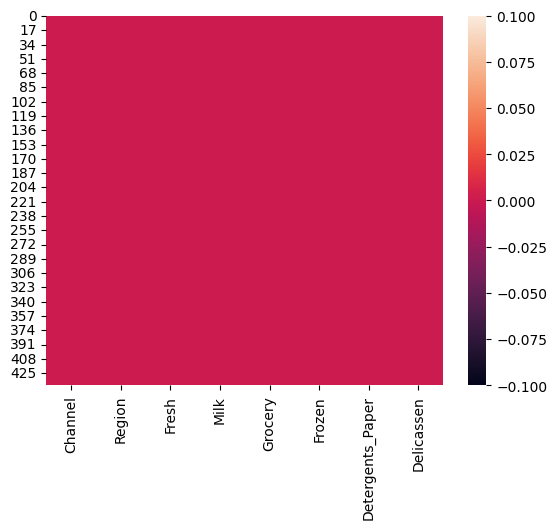

In [13]:
#Null heatmap to visualize the dataset
sns.heatmap(df.isnull())

Text(0.5, 1.0, 'Correlation')

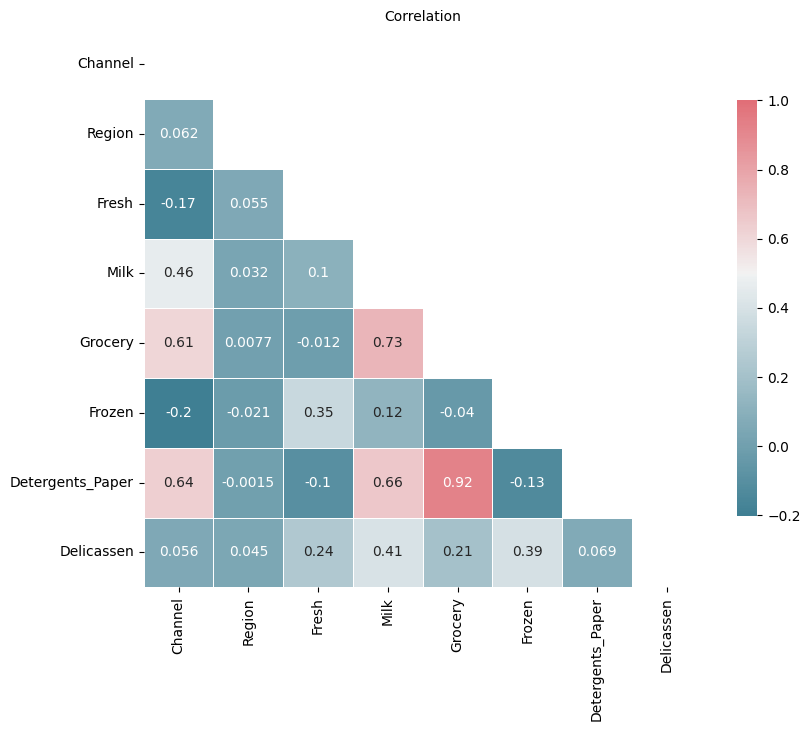

In [14]:
#Checking the correlation
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Drawing heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.5, square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)
plt.title("Correlation", fontsize =10)

In [15]:
#Target variable 'Channel'. let's see other feature selection techniques.
X = df.drop('Channel', axis=1)
y = df['Channel']

# Apply SelectKBest Algorithm using chi2 score function
kbest_features = SelectKBest(score_func=chi2, k=6)
ord_features = kbest_features.fit(X, y)
df_scores = pd.DataFrame(ord_features.scores_, columns=["Score"])
df_columns = pd.DataFrame(X.columns)
k_features = pd.concat([df_columns, df_scores], axis=1)
k_features.columns=['Features','Score']
k_features

,Features,Score
0,Region,3.981484e-01
1,Fresh,1.674662e+05
2,Milk,8.756852e+05
3,Grocery,1.848001e+06
4,Frozen,1.374907e+05
5,Detergents_Paper,1.401016e+06
6,Delicassen,7.183162e+03


In [17]:
#the sorted values of mean higer score
mutual_info = mutual_info_classif(X, y)
mutual_data = pd.Series(mutual_info, index = X.columns)
mutual_data.sort_values(ascending=False)

Grocery             0.244043
Detergents_Paper    0.222686
Milk                0.101372
Delicassen          0.044119
Frozen              0.040019
Fresh               0.028181
Region              0.014609
dtype: float64

In [18]:
#Let's encode and select the best features

label_encoder = LabelEncoder()
df_1 = df.apply(label_encoder.fit_transform)
# X_feature = df.drop('Channel', axis=1)
# Y_label = df['Channel']
X = df_1.drop('Channel', axis=1)
Y = df_1['Channel']


#trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=15)
trans = GenericUnivariateSelect(score_func = mutual_info_classif, mode='percentile', param = 70)
trans_feat = trans.fit_transform(X, Y)
columns_ = df_1.iloc[:, 1:].columns[trans.get_support()].values

# X_feature as tranformed top feature variables
X_feature = pd.DataFrame(trans_feat, columns=columns_)

# Y_label with only target variable
Y_label = Y

X_feature.columns

Index(['Region', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper'], dtype='object')

# [2] Data visualization

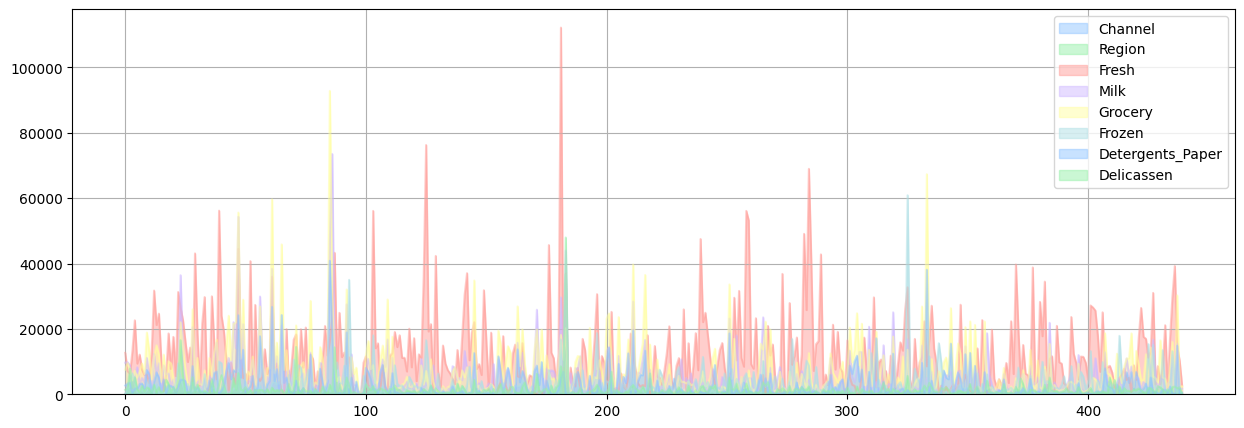

In [19]:
#1. Univariate analysis [Each feature individually]
#Plotting all features stacked
df.plot.area(stacked=False,figsize=(15,5))
pylab.grid(); pylab.show()

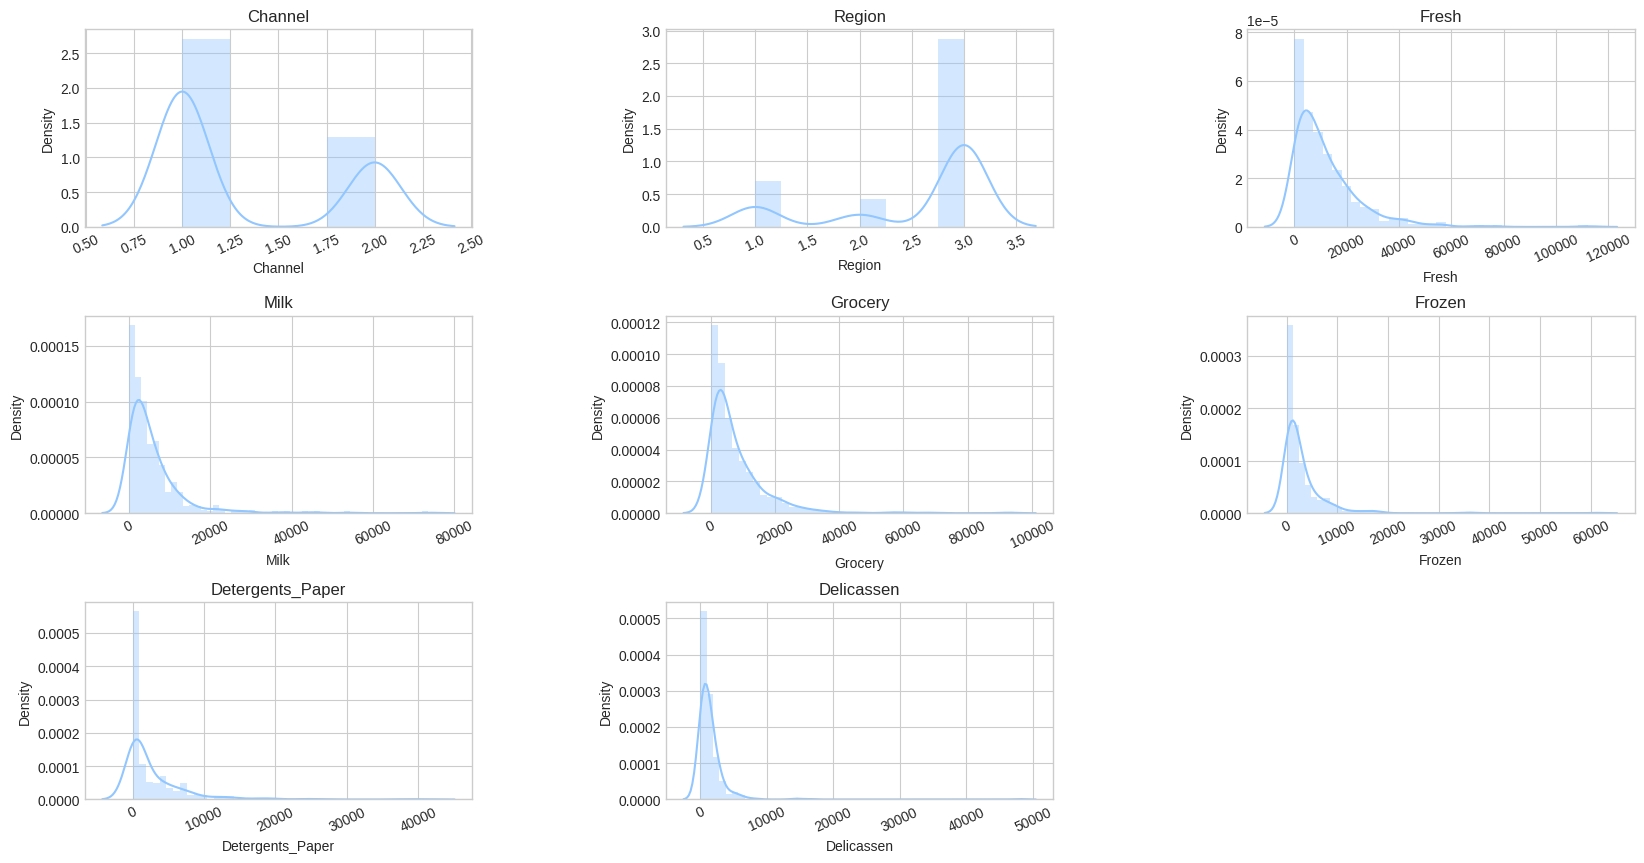

In [20]:
#Histplot for eac feature
def plot_draw(df, cols=5, width=10, height=10, hspace=0.2, wspace=0.5):
    """Ploting the individual feature histplot"""
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(df.shape[1]) / cols)
    for i, column in enumerate(df.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if df.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=df)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(df[column])
            plt.xticks(rotation=25)

plot_draw(df, cols=3, width=20, height=10, hspace=0.45, wspace=0.5)

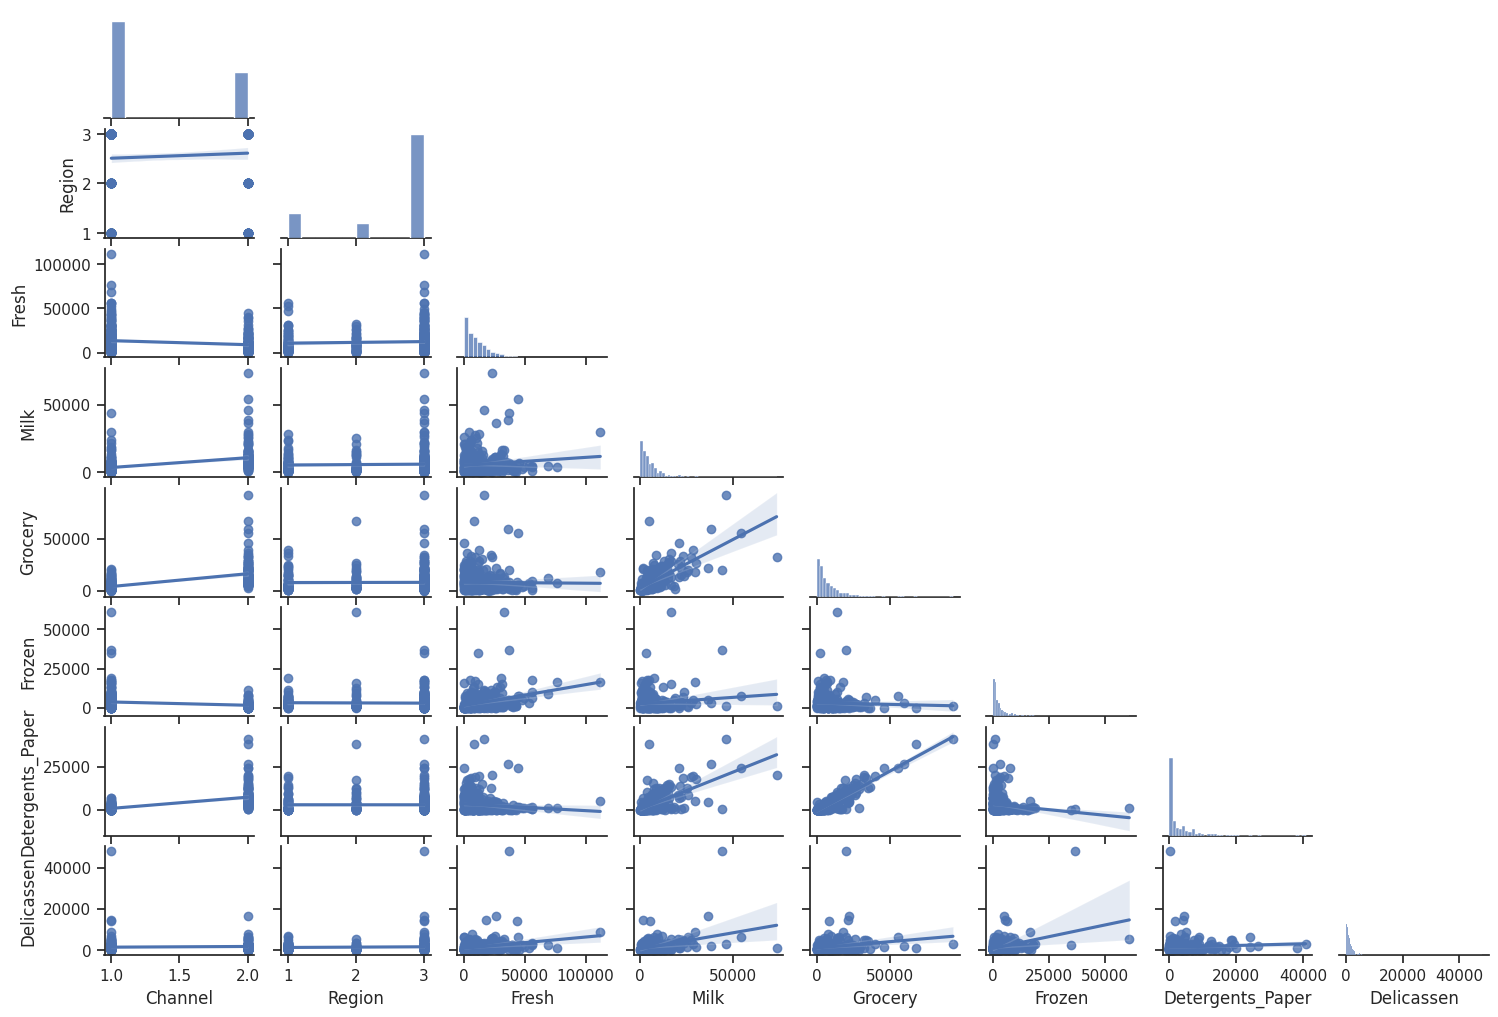

In [21]:
#2. Bivariate analysis [Pairwise]
#This is not needed for our dataset perspective but for visulization purpose let's plot
sns.set(style="ticks")
graph = sns.pairplot(df,corner=True,kind='reg')
graph.fig.set_size_inches(15,10)

In [22]:
#Let's check central tendency for each feature
df.agg(['median','mean','std']).round(2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
median,1.00,3.00,8504.00,3627.00,4755.50,1526.00,816.50,965.50
mean,1.32,2.54,12000.30,5796.27,7951.28,3071.93,2881.49,1524.87
std,0.47,0.77,12647.33,7380.38,9503.16,4854.67,4767.85,2820.11


In [23]:
#Outlier detection, measure in percentage
num_col = df.columns.tolist()
#Function to detect the outliers using IQR
def outlier_count(col, data=df):
    #q75, q25 = np.percentile(data[col], [25, 75])
    # calculate the interquartile range(Q1,Q3)
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    min_val = Q1 - (IQR*1.5)
    max_val = Q3 + (IQR*1.5)
    #Finding the length of data that is more than max threshold and lesser than min threshold
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('{:<20} {:<20} {:.2f}%'.format(col,outlier_count,outlier_percent))

#Looping over all the numerical columns to outlier count function to find the total count of outliers in data.
print("\n"+20*'*' + ' Outliers ' + 20*'*'+"\n")
print('{:<20} {:<20} {:<20}'.format('Variable Name','Number Of Outlier','Outlier(%)'))
for col in num_col:
    outlier_count(col)


******************** Outliers ********************

Variable Name        Number Of Outlier    Outlier(%)          
Channel              0                    0.00%
Region               0                    0.00%
Fresh                20                   4.55%
Milk                 28                   6.36%
Grocery              24                   5.45%
Frozen               43                   9.77%
Detergents_Paper     30                   6.82%
Delicassen           27                   6.14%


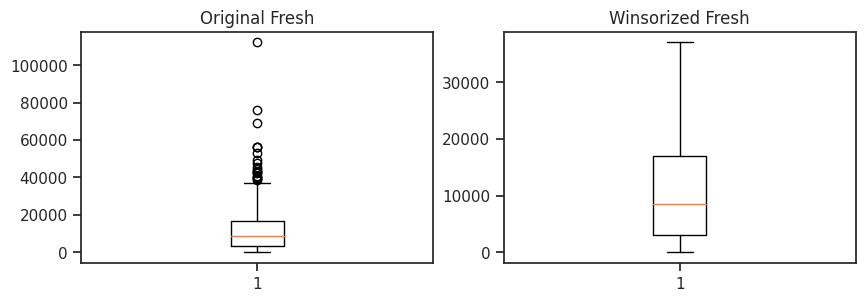

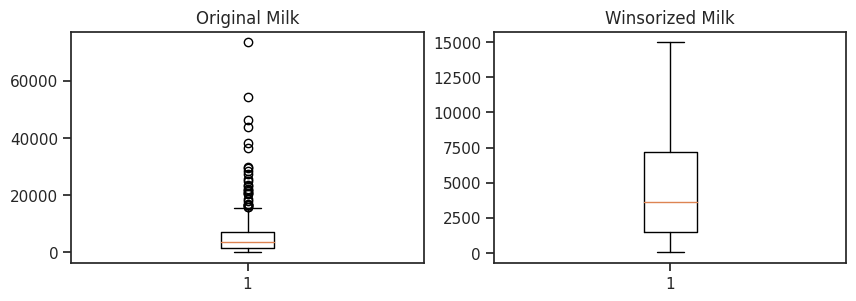

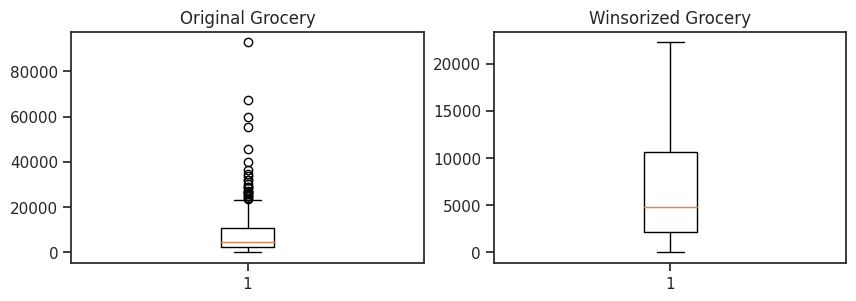

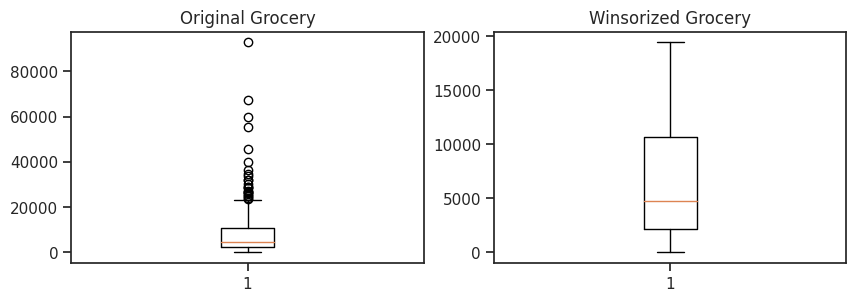

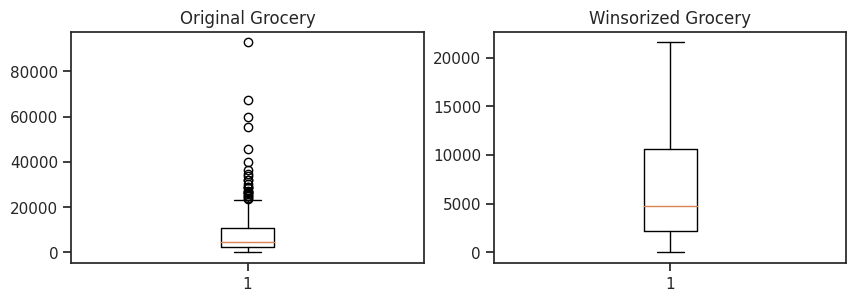

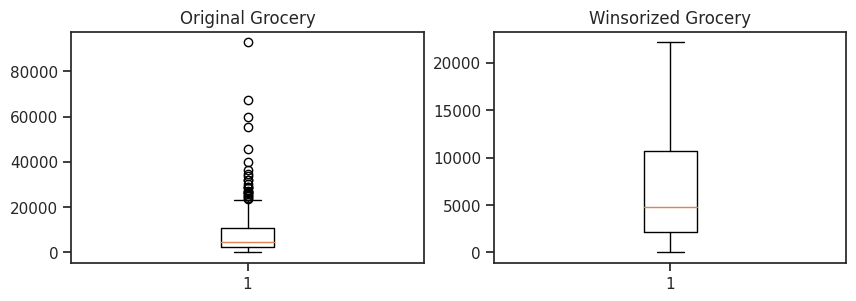

In [24]:
#Using function applying winsorize technique to cap the outliers and adding the new winsorized column to winsor_dict
# which can be used for futher implementation.
def winsor(col, lower_limit=0, upper_limit=0, show_plot=True):

    #Using scipy.stats.mstats.winsorize to each column
    winsor_data = winsorize(df[col], limits=(lower_limit, upper_limit))

    #Assigning the winsorized data from each column to  dict
    winsor_dict[col] = winsor_data

    #Using box plot, visializing the data to check the outliers before and after winsorizing
    if show_plot == True:
        plt.figure(figsize=(10,3))

        #draw plot with original dataset
        plt.subplot(121)
        plt.boxplot(df[col])
        plt.title('Original {}'.format(col))

        #draw plot with winsorized dataset
        plt.subplot(122)
        plt.boxplot(winsor_data)

        #assigning titile to the plot
        plt.title('Winsorized {}'.format(col))
        plt.show()


#Creating an empty dict to load all the winsorised data
winsor_dict = {}

#From the analysis found from the box plot, based on the outliers position,
#various limit has been experimented to limit the outlier count.

#In boxplot 2 ['Fresh'], It is seen that the outliers are in the upper boundanday of the plot,
winsor(num_col[2], upper_limit = 0.0455, show_plot=True)

#In boxplot 3 ['Milk'], It is seen that the outliers are in the upper boundanday of the plot,
winsor(num_col[3], upper_limit = 0.067, show_plot=True)

#In boxplot 4 ['grocery'], It is seen that the outliers are in the upper boundanday of the plot,
winsor(num_col[4], upper_limit = 0.06, show_plot=True)

#In boxplot 5 ['Frozen'], It is seen that the outliers are in the upper boundanday of the plot,
winsor(num_col[4], upper_limit = 0.0977, show_plot=True)

#In boxplot 6 ['Detergents_Paper'], It is seen that the outliers are in the upper boundanday of the plot,
winsor(num_col[4], upper_limit = 0.0682, show_plot=True)

#In boxplot 7 ['Delicassen'], It is seen that the outliers are in the upper boundanday of the plot,
winsor(num_col[4], upper_limit = 0.0614, show_plot=True)

**Feature Transformation & Normalization**

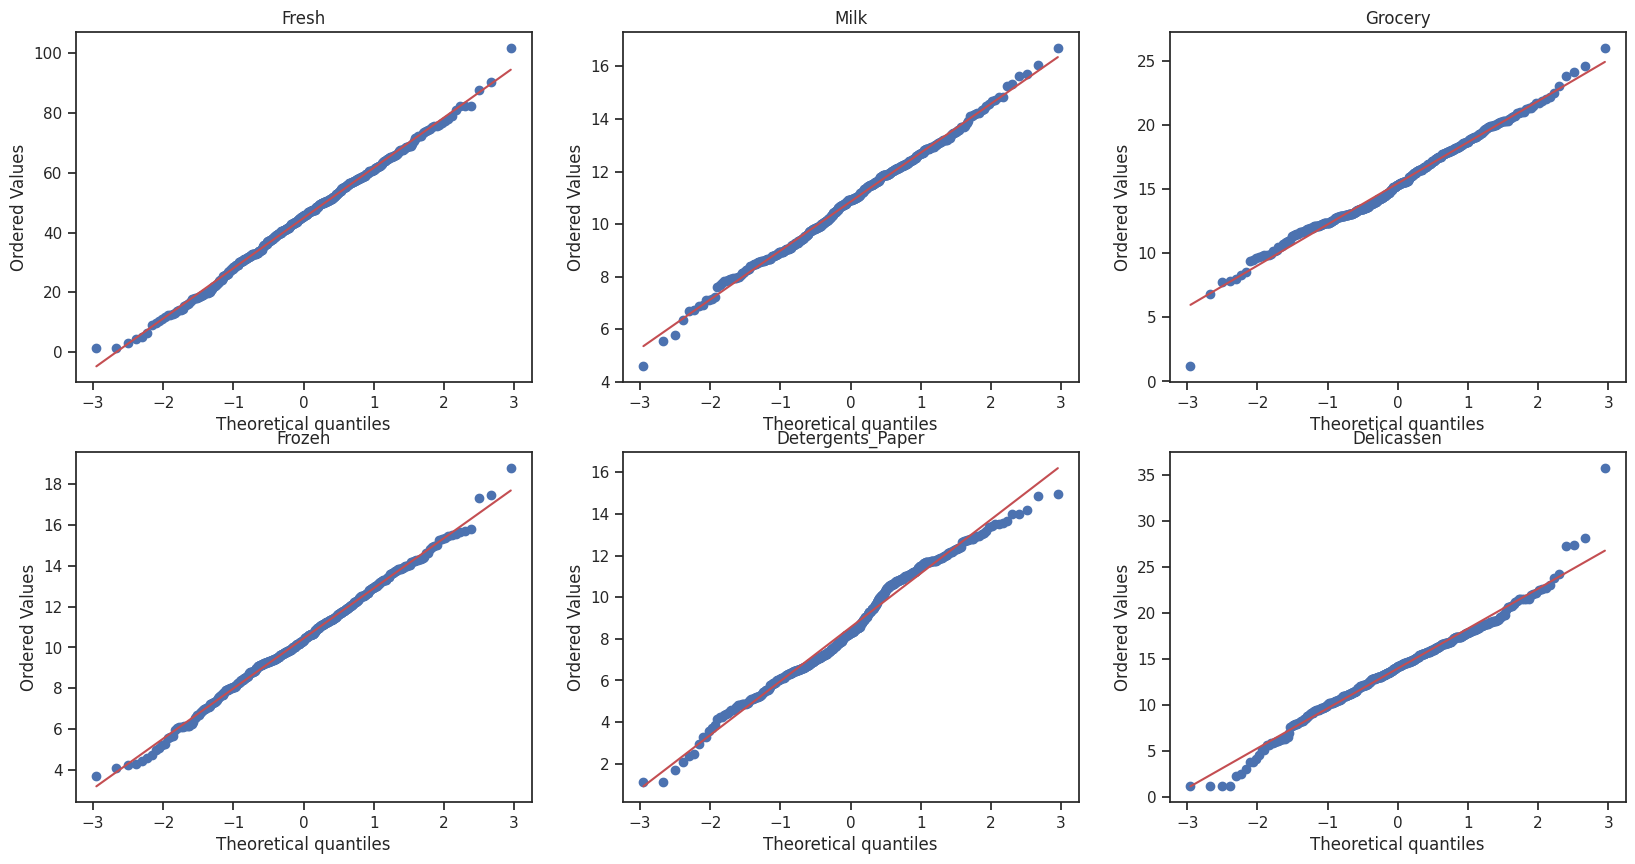

,Statistic,p-value
Fresh,0.997444,0.737557
Milk,0.996949,0.584163
Grocery,0.989161,0.002424
Frozen,0.997237,0.673468
Detergents_Paper,0.985208,0.000185
Delicassen,0.981869,0.000026


In [25]:
#All the variable are statistically non normally distributed.Let's try BoxCox transformation
shapiro_test = {}
lambdas = {}
j=2
plt.figure(figsize=(20, 10))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    x, lbd = boxcox(df[df.columns[j]])
    probplot(x = x, dist=norm, plot=ax)
    plt.title(df.columns[j])
    shapiro_test[df.columns[j]] = shapiro(x)
    lambdas[df.columns[j]] = lbd
    j+=1

plt.show()

pd.DataFrame(shapiro_test, index=['Statistic', 'p-value']).transpose()

In [26]:
#Using standard scalaer let's Transform & Normalize the data and visulize it.
sc=StandardScaler()
scaled_data=sc.fit_transform(df)

norm_data=normalize(df)

df=pd.DataFrame(scaled_data,columns=df.columns)
df_SN=pd.DataFrame(norm_data,columns=df.columns)
df_SN.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.000112,0.000168,0.708333,0.539874,0.422741,0.011965,0.149505,0.074809
1,0.000125,0.000188,0.442198,0.614704,0.599540,0.110409,0.206342,0.111286
2,0.000125,0.000187,0.396552,0.549792,0.479632,0.150119,0.219467,0.489619
3,0.000065,0.000194,0.856837,0.077254,0.272650,0.413659,0.032749,0.115494
4,0.000079,0.000119,0.895416,0.214203,0.284997,0.155010,0.070358,0.205294


We have normalized the dataset. but, here, for modeling purpose for our dataset, it would be better to go without normalization.

# [4] Unsupervised learning

For using K-Means algorithm. Let's determine the optimal value of clusters here.

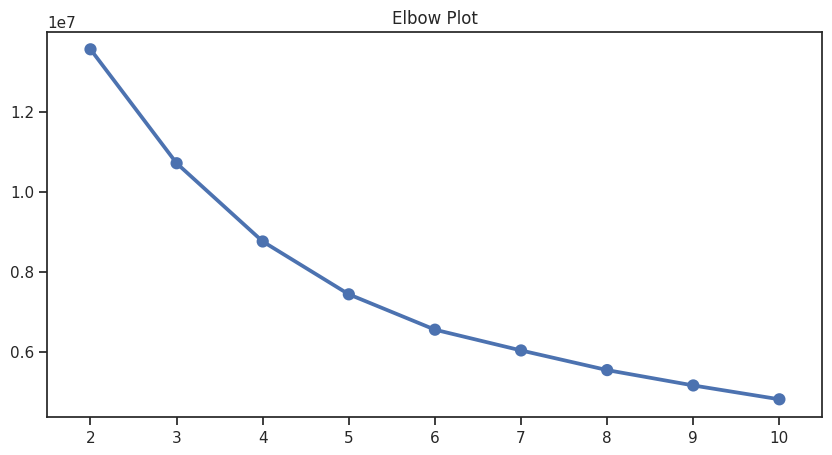

In [27]:
#As we already have our scaled data ready, lets do principle component analysis
#and print elbow plot to determine the optimal number of clusters.

PCA_train = PCA(2).fit_transform(scaled_data)
ps = pd.DataFrame(PCA_train)

le = {}
for k in range(2,11):
    kmeans = KMeans(n_clusters = k, random_state=123)
    Y_label = kmeans.fit_predict(X_feature)
    le[k] = kmeans.inertia_

plt.figure(figsize=(10,5))
plt.title('Elbow Plot')
sns.pointplot(x = list(le.keys()), y = list(le.values()))

plt.show()

Here, we can try 3, 4 or 5 clusters as per above. strong declination plot.

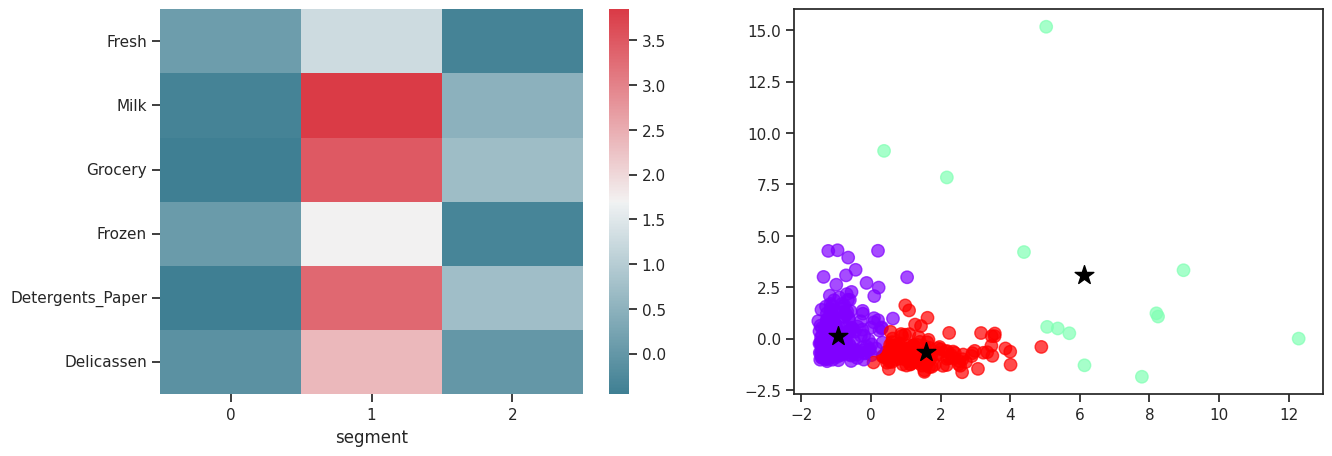

In [28]:
#Let's parallely plot the heatmap and scatter plot to see the segmentation
#Cluster=3
kmeans = KMeans(n_clusters=3, random_state=123).fit(ps)
y_kmeans = kmeans.predict(ps)
df = df.assign(segment = kmeans.labels_)
kmeans_3_means = df.drop(['Channel','Region'], axis=1).groupby('segment').mean()

lab = kmeans.labels_

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(kmeans_3_means.T, cmap=cmap)

plt.subplot(1,2,2)
plt.scatter(ps[0], ps[1],c = y_kmeans, s=80, cmap='rainbow',alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker = '*', color='black', s=200)

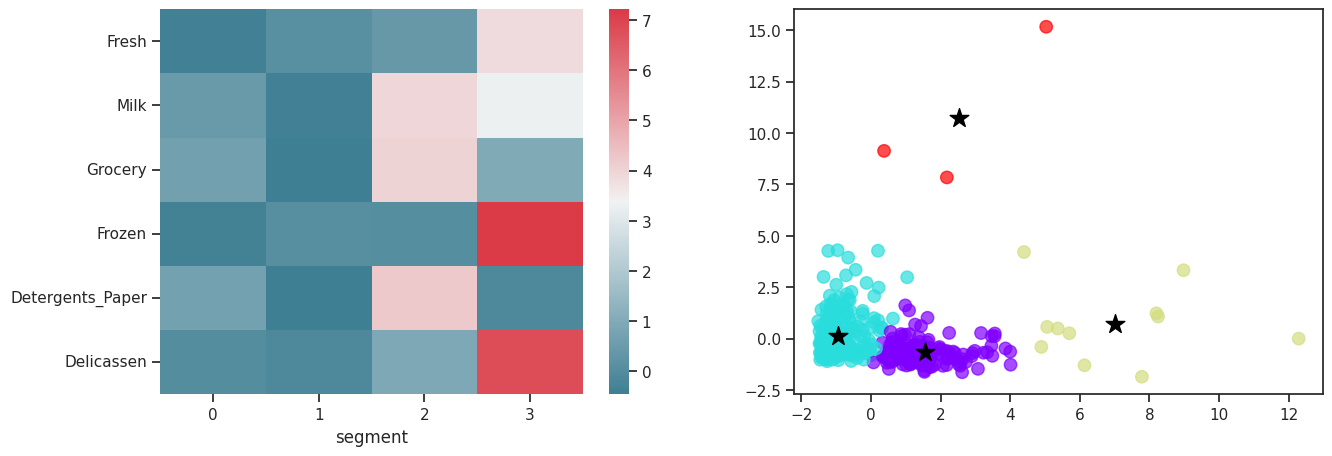

In [29]:
#Let's parallely plot the heatmap and scatter plot to see the segmentation
#Cluster=4
kmeans = KMeans(n_clusters=4, random_state=123).fit(ps)
y_kmeans = kmeans.predict(ps)
df = df.assign(segment = kmeans.labels_)
kmeans_3_means = df.drop(['Channel','Region'], axis=1).groupby('segment').mean()

lab = kmeans.labels_

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(kmeans_3_means.T, cmap=cmap)

plt.subplot(1,2,2)
plt.scatter(ps[0], ps[1],c = y_kmeans, s=80, cmap='rainbow',alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker = '*', color='black', s=200)

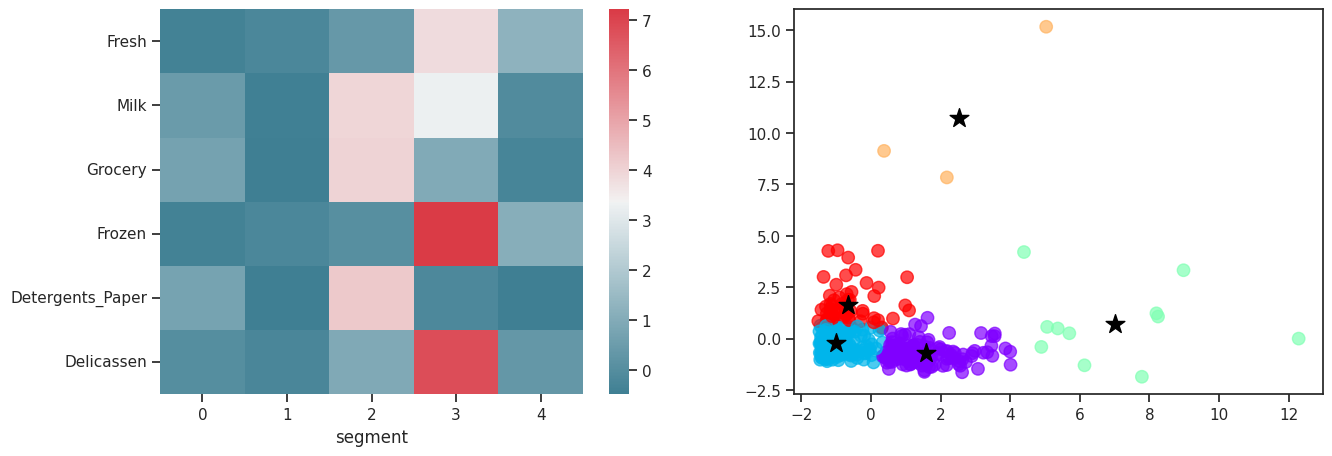

In [30]:
#Let's parallely plot the heatmap and scatter plot to see the segmentation
#Cluster=5
kmeans = KMeans(n_clusters=5, random_state=123).fit(ps)
y_kmeans = kmeans.predict(ps)
df = df.assign(segment = kmeans.labels_)
kmeans_3_means = df.drop(['Channel','Region'], axis=1).groupby('segment').mean()

lab = kmeans.labels_

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(kmeans_3_means.T, cmap=cmap)

plt.subplot(1,2,2)
plt.scatter(ps[0], ps[1],c = y_kmeans, s=80, cmap='rainbow',alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], marker = '*', color='black', s=200)

Let's try other kind of clustering.

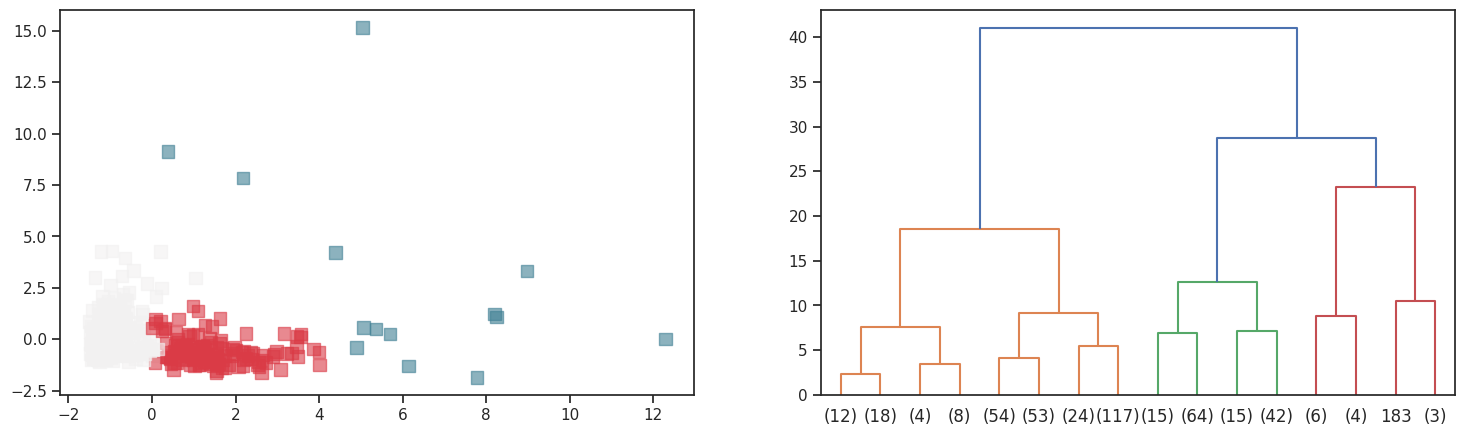

In [31]:
#Agglomerative Clustering
agc = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='ward')
y_agc_pred = agc.fit_predict(ps)
plt.figure(figsize =(18,5))

plt.subplot(1,2,1)
plt.scatter(ps[0], ps[1],c = y_agc_pred, s=80, cmap=cmap,alpha=0.6,marker='s')

plt.subplot(1,2,2)
dend=shc.dendrogram(shc.linkage(ps,method='ward') ,truncate_mode='level', p=3)
plt.show()


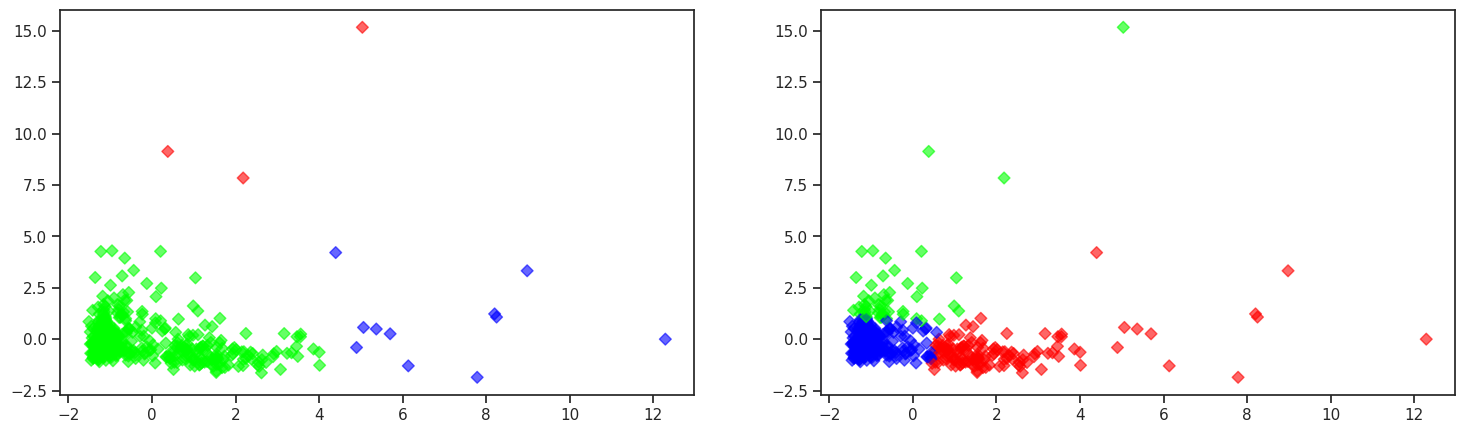

In [32]:
#Birch clustering
brc = Birch(branching_factor=500, n_clusters=3, threshold=1.5)
brc.fit(ps)
labels = brc.predict(ps)
plt.figure(figsize =(18,5))

plt.subplot(1,2,1)
plt.scatter(ps[0], ps[1], c=labels, cmap='brg',alpha=0.6,marker='D')

#MiniBatchKMeans
mb = MiniBatchKMeans(n_clusters=3, random_state=0)
mb.fit(ps)
labels = mb.predict(ps)

plt.subplot(1,2,2)
plt.scatter(ps[0], ps[1], c=labels, cmap='brg',alpha=0.6,marker='D')


plt.show()

In [33]:
end = time. time()
sec = (end - start)
print(f'Total time taken to complete the execution :{sec} seconds(s)')

Total time taken to complete the execution :293.6072630882263 seconds(s)
